<Body>   
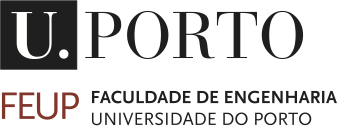   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# Colorization of LiDAR Point Clouds Using Visual Data for Enhanced 3D Scene Representation

In this task, you are required to perform the texturization of a LiDAR-generated point cloud using visual data from an onboard camera. Given that the camera-LiDAR setup has been extrinsically calibrated and the camera itself has undergone intrinsic calibration, your objective is to accurately use color information from the camera images onto the corresponding points in the LiDAR cloud. This process involves mapping each LiDAR point, which has precise spatial information but lacks color, to the pixel in the camera image, thus assigning it an RGB value. You must account for differences in resolution, viewpoint, and field of view between the camera and LiDAR sensors.

Through this, you will create a realistic, textured representation of the scene, enhancing the interpretability and detail of the 3D model by merging spatial and visual information.

> **Expected output:** a point cloud with RGB colors in each point.





This assignment use data collected by an Unmanned Aerial Vehicle (UAV) during the inspection routines of a offshore structure in the [ATLANTIS Test Centre](https://www.linkedin.com/company/68810369/). The data retrieved by the UAV includes:

* **LiDAR**: which is an ouster [OS1-64](https://ouster.com/products/hardware/os1-lidar-sensor).

* **Visual information**: obtained by a 640x480 resolution camera, with the lens distortion model $D_v$ and intrinsic matrix ($K_v$).

> `Dv: [-0.21292081375160646, 0.1767752984756973, 0.00016650108739115778, -7.265397248140523e-05, -0.05302482500821179]`

> `Kv: [791.177953960177, 0.0, 339.436073232339, 0.0, 791.2141134510654, 257.3051663940424, 0.0, 0.0, 1.0]`


The extrinsic calibration parameters of this sensor setup is the following:

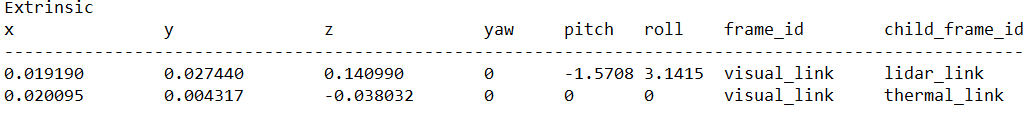

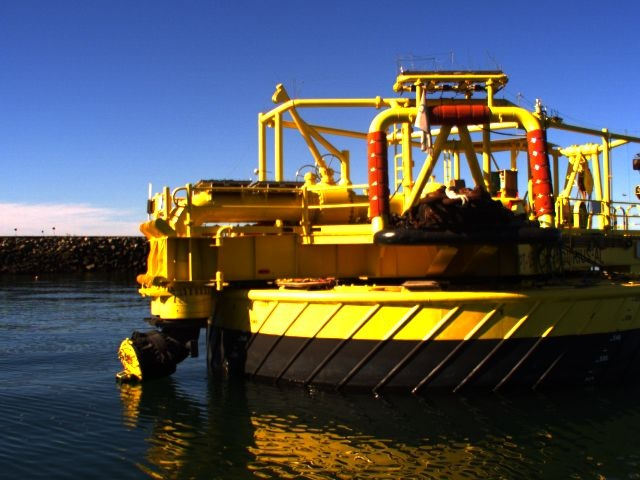

Figure 1 - Visual Images collected by UAV.

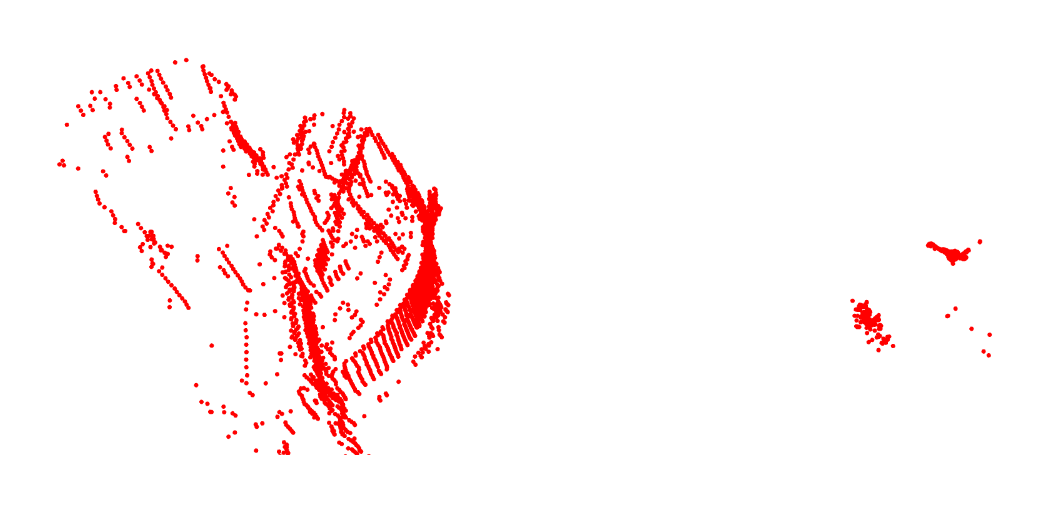

Figure 2 - Point cloud collected by UAV.

## Prepare Libraries and Download dataset

In [ ]:
# Install Open3D library
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninst

In [ ]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d

In [ ]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

In [ ]:
!wget 'https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EU91jtOCygFFgkkekfz2MMUBEbT7RCV-VNYsfDG0Kqm7Lg?download=1' -O DURIUS_d1.zip

--2025-01-10 22:53:40--  https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EU91jtOCygFFgkkekfz2MMUBEbT7RCV-VNYsfDG0Kqm7Lg?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/RAVEN/PM_dataset_DURIUS_RAVEN_data_1.zip?ga=1 [following]
--2025-01-10 22:53:41--  https://uporto-my.sharepoint.com/personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/RAVEN/PM_dataset_DURIUS_RAVEN_data_1.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 81997028 (78M) [application/x-zip-compressed]
Saving to: ‘DURIUS_d1.zip’

DURIUS_d1.zip       100%[===================>]  78.20M  40.3MB/s    in 1.9s    

2025-01-10 22:53:4

In [ ]:
# Extract point clouds from ZIP file.
import zipfile
import os

with zipfile.ZipFile("DURIUS_d1.zip", mode="r") as archive:
  for file in archive.namelist():
    archive.extract(file, "dataset_uav/")

## Loading Images and Point Clouds

In [ ]:
DIR_PCL = "dataset_uav/data_1/PCD/"
DIR_RGB = "dataset_uav/data_1/RGB/"

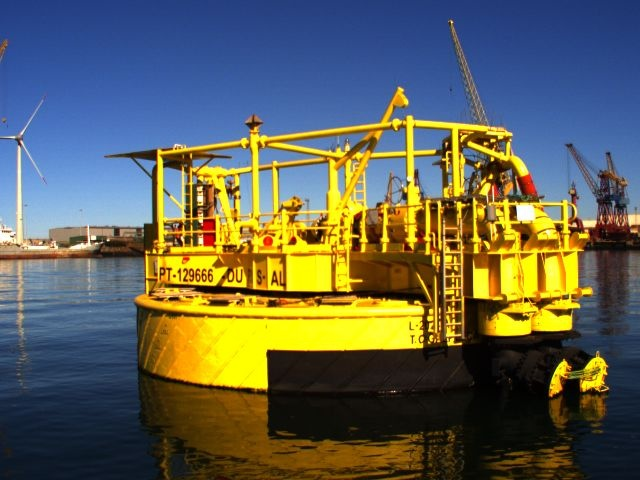

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread(DIR_RGB+"image_1693472857485557608.jpg")
cv2_imshow(image)

pt_example = o3d.io.read_point_cloud(DIR_PCL+"pointcloud_1693472857608952.pcd", format='pcd')
if pt_example.is_empty():
  exit()


In [ ]:
o3d.visualization.draw_geometries([pt_example])

Output hidden; open in https://colab.research.google.com to view.

## Pre-processing the point cloud
Apply some pre-processing techniques to improve the quality of the 3D Data.

#### **LiDAR out-of-range measurements**
LiDAR sensors are widely used for detecting objects, mapping environments, and estimating distances. However, they can encounter measurement errors, including out-of-range measurements, where the sensor detects a value close to zero despite no valid return signal. Here’s a breakdown of why this happens and potential solution:
*   Low Reflectivity of Surfaces
*   Out-of-Detection Range
*   Interference

To mitigate these errors, a **pass-through filter** is applied to each point cloud, removing incorrect measurements near the origin.

According to the LiDAR datasheet, measurements under 500 mm are considered invalid and should be excluded.

#### `pass_through_filter`
This function filters a point cloud to remove points inside a specified region of interest (ROI) defined by x, y, and z ranges.

1. **Inputs**:
   - `pcd_original`: Original point cloud.
   - `x_range`, `y_range`, `z_range`: Bounds for the ROI along each axis.
   - `show`: Boolean to optionally visualize results.

2. **Process**:
   - Convert points to a NumPy array.
   - Create a mask for points within the ROI.
   - Separate points into:
     - **Outliers** (inside ROI).
     - **Filtered points** (outside ROI).

3. **Outputs**:
   - `filtered_pcd`: Point cloud containing points outside the ROI.
   - Optionally visualizes:
     - **Filtered points**: Gray.
     - **Outliers**: Red.

4. **Visualization**:
   - Displays the filtered and outlier points for clarity.

**Returns**: The filtered point cloud excluding out-of-range points.

In [ ]:
def pass_through_filter(pcd_original, x_range, y_range, z_range, show=False):
    # Deep copy of the original point cloud
    pcd = copy.deepcopy(pcd_original)

    # Get all points as a numpy array
    all_points = np.asarray(pcd.points)

    # Create a mask for points inside the ROI
    inside_mask = (
        (all_points[:, 0] >= x_range[0]) & (all_points[:, 0] <= x_range[1]) &
        (all_points[:, 1] >= y_range[0]) & (all_points[:, 1] <= y_range[1]) &
        (all_points[:, 2] >= z_range[0]) & (all_points[:, 2] <= z_range[1])
    )

    # Points outside the ROI
    points_outside_roi = all_points[~inside_mask]

    # Points inside the ROI
    points_inside_roi = all_points[inside_mask]

    # Filtered point cloud
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(points_outside_roi)

    # Ouliers point cloud
    ouliers_pcd = o3d.geometry.PointCloud()
    ouliers_pcd.points = o3d.utility.Vector3dVector(points_inside_roi)

    # Optionally show the point cloud
    if show:
        print(f"Out-of-range noise removal")
        print(f"Number of inliers points (filtered): {len(filtered_pcd.points)}")
        print(f"Number of outliers points (out-of-range) : {len(ouliers_pcd.points)}")
        # Visualize inliers and outliers
        filtered_pcd.paint_uniform_color([0.8, 0.8, 0.8])  # Gray for inliers
        ouliers_pcd.paint_uniform_color([1.0, .0, 0.0])  # Red for outliers
        # Combine for visualization
        o3d.visualization.draw_geometries([filtered_pcd, ouliers_pcd])

    return filtered_pcd

### **Cluster-based filtering**
To achieve the goal of reconstructing a 3D representation of the CALM buoy, cluster-based filtering using algorithms like KMeans is a practical choice. Here's why it was selected over other methods, such as statistical outlier removal, and how it contributes to preserving critical data.

Using a clustering algorithm like KMeans (K=2):
*   **Cluster 1**: Points representing the CALM buoy.
*   **Cluster 2**: Noise points (e.g., random measurements or outliers)
*   The cluster with the **largest number of points** is assumed to represent the CALM buoy, as it forms the dominant structure in the data.

##### Why Clustering Instead of Statistical Outlier Removal?


*   **Retains Critical Data:** Statistical outlier removal methods (e.g., mean distance thresholding or z-score-based filtering) operate on point-level statistics. These approaches might inadvertently remove valid points from the buoy that are important for its 3D reconstruction. On the other hand, cluster-based filtering, evaluates the global structure of the data, preserving all points in the primary cluster.

*   **Handles Complex Noise Patterns:** Noise in LiDAR data may not follow a simple statistical distribution, making it difficult to define appropriate thresholds for statistical filtering. Clustering algorithms naturally separate the buoy from noise based on spatial proximity and density, regardless of noise patterns.

In [ ]:
from sklearn.cluster import KMeans

def remove_outliers(pcd_original, n_clusters=2, show=False):
    # Copy the point cloud
    pcd = copy.deepcopy(pcd_original)

    # Remove out-of-range measurements
    threshold = 0.5 # Sensor range (500mm from datasheet)
    x_range = (-threshold, threshold)
    y_range = (-threshold, threshold)
    z_range = (-threshold, threshold)
    pcd = pass_through_filter(pcd, x_range, y_range, z_range, show=False)

    # Convert the point cloud to a NumPy array
    points = np.asarray(pcd.points)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(points)

    # Count points in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)

    if len(unique_labels) < 2:
        raise ValueError("K-means found fewer than 2 clusters. Try adjusting the data.")

    # Identify the inlier cluster (largest cluster)
    inlier_cloud_label = unique_labels[np.argmax(counts)]
    inlier_cloud_indices = np.where(labels == inlier_cloud_label)[0]

    # Identify the outlier cluster (smallest cluster)
    outlier_cloud_label = unique_labels[np.argmin(counts)]
    outlier_cloud_indices = np.where(labels == outlier_cloud_label)[0]

    # Select the points corresponding to inliers and outliers
    inlier_cloud = pcd.select_by_index(inlier_cloud_indices, invert=False)
    outlier_cloud = pcd.select_by_index(outlier_cloud_indices, invert=False)
    inlier_cloud = pcd.select_by_index(inlier_cloud_indices, invert=False)
    outlier_cloud = pcd.select_by_index(outlier_cloud_indices, invert=False)

    if show:
        print(f"Noise removal")
        print(f"Number of inlier points (clustered): {len(inlier_cloud_indices)}")
        print(f"Number of outlier points (noise): {len(outlier_cloud_indices)}")
        # Visualize inliers and outliers
        inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])  # Gray for inliers
        outlier_cloud.paint_uniform_color([1.0, .0, 0.0])  # Red for outliers
        # Combine for visualization
        o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

    return inlier_cloud

In [ ]:
# Remove outliers by selecting largest cluster
pcd_filtered = remove_outliers(pt_example, show=True)

Noise removal
Number of inlier points (clustered): 2349
Number of outlier points (noise): 571


## Define the Intrinsic and Extrinsic matrices, and transform the data for different coordinates

Use the Open3D objects/methods to modify the coordinate system of the point cloud.



#### `get_extrinsic_matrix`
This function computes a 4x4 extrinsic transformation matrix given rotation angles (roll, pitch, yaw) and translation (tx, ty, tz).

1. **Rotation Matrices**:
   - `Rx`: Rotation around the x-axis (roll).
   - `Ry`: Rotation around the y-axis (pitch).
   - `Rz`: Rotation around the z-axis (yaw).

2. **Combined Rotation**:
   - `R = Rz @ Ry @ Rx` (applied in ZYX order).

3. **Translation Vector**:
   - `t = [tx, ty, tz]`.

4. **Extrinsic Matrix**:
   Combines rotation (`R`) and translation (`t`) into a 4x4 matrix:

   ```python
   extrinsic_matrix = [[R | t],
                       [0  0  0  1]]

                

In [ ]:
import numpy as np
import open3d as o3d

def get_extrinsic_matrix(roll, pitch, yaw, tx, ty, tz):
    # Rotation matrices around x, y, z
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix
    R = Rz @ Ry @ Rx  # Matrix multiplication order: Rz * Ry * Rx

    # Translation vector
    t = np.array([tx, ty, tz]).reshape((3, 1))

    # Extrinsic matrix
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = R
    extrinsic_matrix[:3, 3] = t.flatten()

    return extrinsic_matrix

# Example usage of the extrinsic matrix with roll, pitch, yaw, and translation
tx = 0.019190
ty = 0.027440
tz = 0.140990
yaw = 0.0
pitch = -1.5708
roll = 3.1415

# Create the extrinsic matrix
extrinsic_matrix_lidar_camera = get_extrinsic_matrix(roll, pitch, yaw, tx, ty, tz)

# Define the intrinsic camera parameters
width = 640
height = 480
fx = 791.17
fy = 791.21
cx = 339.44
cy = 257.31

camera_visual = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

#### **Camera Parameters**

**Intrinsic Parameters**:
- These describe the internal characteristics of the camera.
- **Intrinsic Matrix**: It maps 3D points in the camera's coordinate system to 2D image coordinates.
  
  $$
  \text{Intrinsic Matrix} =
  \begin{bmatrix}
  f_x & 0 & c_x \\
  0 & f_y & c_y \\
  0 & 0 & 1
  \end{bmatrix}
  $$
  - $( f_x, f_y )$: Focal lengths in pixels.
  - $( c_x, c_y )$: Optical center.

**Distortion Coefficients**:
- Corrects lens distortions like barrel or pincushion distortion.
- Coefficients applied to adjust the image for better accuracy in projection.

Sources:


*   OPenCV: [Camera Calibration](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)


*   Wikipedia: [Types of Distortion](https://en.wikipedia.org/wiki/Distortion_%28optics%29)

In [ ]:
# Apply the transformation to align the point cloud to the camera frame
pcd_filtered.transform(extrinsic_matrix_lidar_camera)

# Access transformed points (Point cloud in camera frame)
points_cam = np.asarray(pcd_filtered.points)

# Print intrinsic matrix and extrinsic matrix for verification
print("Intrinsic Matrix:\n", camera_visual.intrinsic_matrix)
print("Extrinsic Matrix:\n", extrinsic_matrix_lidar_camera)
print("3D points in camera frame:\n", points_cam)

Intrinsic Matrix:
 [[791.17   0.   339.44]
 [  0.   791.21 257.31]
 [  0.     0.     1.  ]]
Extrinsic Matrix:
 [[-3.67320510e-06 -9.26535897e-05  9.99999996e-01  1.91900000e-02]
 [ 0.00000000e+00 -9.99999996e-01 -9.26535897e-05  2.74400000e-02]
 [ 1.00000000e+00 -3.40335638e-10  3.67320509e-06  1.40990000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3D points in camera frame:
 [[ 5.39439187  2.26333857 16.64456074]
 [ 5.38706828  2.36135525 16.60790172]
 [ 5.38677208  2.46221088 16.59232472]
 ...
 [-7.3599785  -3.02611702 24.87364189]
 [-7.3639596  -2.87586555 24.90524488]
 [-7.64172039 -2.87217501 24.80493086]]


## Convert 3D Points to 2D Image Plane

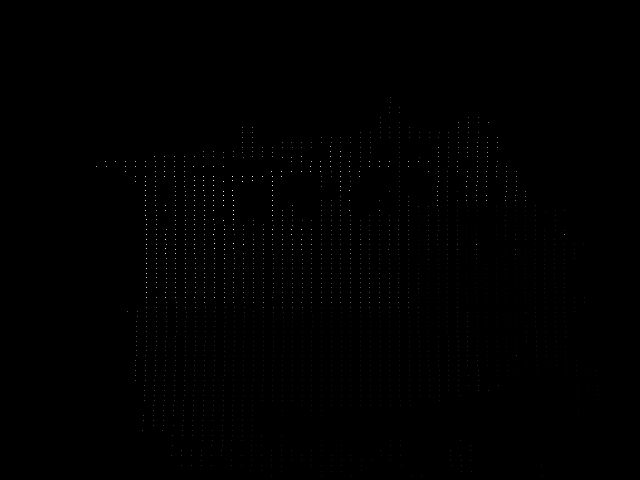

In [ ]:
# Assume `points_cam` is an Nx3 array of 3D points in the camera frame
# You would obtain this by transforming your LiDAR points using the extrinsic matrix as shown before
# Here we assume `camera_visual` holds the camera intrinsic parameters

# Initialize the range map to visualize depth
range_map = np.zeros((camera_visual.height, camera_visual.width), dtype=np.uint8)

# Calculate z_min and z_max for depth scaling to grayscale values
z_max = np.max(points_cam[:, 2])
z_min = np.min(points_cam[:, 2])
z_scale = 255.0 / (z_max - z_min)

# Intrinsic matrix of the camera
intrinsic_matrix = camera_visual.intrinsic_matrix

# Initialize a list to store pixel coordinates
pixel_coords = []

for pt in points_cam:
    # Check if the point is in front of the camera (positive z direction)
    if pt[2] <= 0:
        continue

    # Project the 3D point (X, Y, Z) to 2D pixel coordinates (x, y)
    x = (intrinsic_matrix[0, 0] * pt[0] / pt[2]) + intrinsic_matrix[0, 2]
    y = (intrinsic_matrix[1, 1] * pt[1] / pt[2]) + intrinsic_matrix[1, 2]

    # Round x and y to the nearest pixel coordinates
    x, y = int(round(x)), int(round(y))

    # Check if the projected point is within the image bounds
    if 0 <= x < camera_visual.width and 0 <= y < camera_visual.height:
        # Map depth (Z value) to a grayscale value for visualization
        depth_map_pt = int((pt[2] - z_min) * z_scale)
        range_map[y, x] = depth_map_pt
        pixel_coords.append([x, y])

# Display the range map
cv2_imshow(range_map)

In [ ]:
# Show the 3D -> 2D image projection as a point cloud
pp_3D_2D_projection = np.column_stack((pixel_coords, np.zeros(len(pixel_coords))))  # Set Z to 0 for 2D projection
pt_image_projection        = o3d.geometry.PointCloud()
pt_image_projection.points = o3d.utility.Vector3dVector(pp_3D_2D_projection)

# Show the 3D -> 2D projection using OpenCV Color Map
range_map_color = cv2.applyColorMap(cv2.cvtColor(range_map, cv2.COLOR_GRAY2BGR), cv2.COLORMAP_HOT)  # COLORMAP_HOT   COLORMAP_RAINBOW (is inverted HOT)

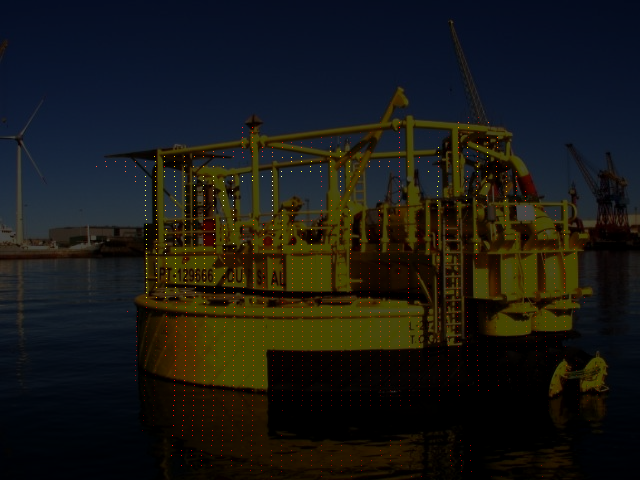

In [ ]:
#Overlaying
image_show = image.copy()
image_projection_color = image_show*0.3 + range_map_color*2-5
cv2_imshow(image_projection_color)

In [ ]:
import numpy as np
import open3d as o3d
import cv2

# Assume `points` is an Nx3 array of 3D points in the LiDAR (or point cloud) coordinate frame
# and `camera_visual` holds the intrinsic parameters for the camera

# Image to sample RGB values from
image_show = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)  # Convert image to RGB if in BGR format

# Prepare to store RGB values for each point
rgb_values = []

# Calculate z_min and z_max for depth scaling if needed (optional)
z_max = np.max(points_cam[:, 2])
z_min = np.min(points_cam[:, 2])
z_scale = 255.0 / (z_max - z_min)

# Intrinsic matrix of the camera
intrinsic_matrix = camera_visual.intrinsic_matrix

for pt in points_cam:
    # Check if the point is in front of the camera (positive z direction)
    if pt[2] <= 0:
        rgb_values.append([0, 0, 0])  # Set black for points behind the camera
        continue

    # Project the 3D point (X, Y, Z) to 2D pixel coordinates (x, y)
    x = (intrinsic_matrix[0, 0] * pt[0] / pt[2]) + intrinsic_matrix[0, 2]
    y = (intrinsic_matrix[1, 1] * pt[1] / pt[2]) + intrinsic_matrix[1, 2]

    # Round x and y to the nearest pixel coordinates
    x, y = int(round(x)), int(round(y))

    # Check if the projected point is within the image bounds
    if 0 <= x < image_show.shape[1] and 0 <= y < image_show.shape[0]:
        # Retrieve the RGB color from the image at the projected 2D location
        rgb = image_show[y, x]  # Get RGB values at this pixel
        rgb_values.append(rgb)  # Append to the RGB list
    else:
        # If outside bounds, assign a default color (e.g., black or gray)
        rgb_values.append([0, 0, 0])

# Convert list to numpy array and normalize to range [0, 1] for Open3D
rgb_values = np.array(rgb_values) / 255.0

# Assign RGB colors to the point cloud in Open3D
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points_cam)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)

# Visualize the colored point cloud
o3d.visualization.draw_geometries([point_cloud])


-----------------------------